In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random

from gym import Env, spaces
import time
font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

In [2]:
class ChopperScape(Env):
    def __init__(self):
        super(ChopperScape, self).__init__()
        

        
        # Define a 2-D observation space
        self.observation_shape = (600, 800, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
    
        
        # Define an action space ranging from 0 to 4
        self.action_space = spaces.Discrete(6,)
                        
        # Create a canvas to render the environment images upon 
        self.canvas = np.ones(self.observation_shape) * 1
        
        # Define elements present inside the environment
        self.elements = []
        
        # Maximum fuel chopper can take at once
        self.max_fuel = 500

        # Permissible area of helicper to be 
        self.y_min = int (self.observation_shape[0] * 0.1)
        self.x_min = 0
        self.y_max = int (self.observation_shape[0] * 0.9)
        self.x_max = self.observation_shape[1]
        
        
    def reset(self):
        # Reset the fuel consumed
        self.fuel_left = self.max_fuel

        # Reset the reward
        self.ep_return  = 0

        # Number of birds
        self.bird_count = 0
        self.fuel_count = 0

        # Determine a place to intialise the chopper in
        x = random.randrange(int(self.observation_shape[0] * 0.05), int(self.observation_shape[0] * 0.10))
        y = random.randrange(int(self.observation_shape[1] * 0.15), int(self.observation_shape[1] * 0.20))

        # Intialise the chopper
        self.chopper = Chopper("chopper", self.x_max, self.x_min, self.y_max, self.y_min)
        self.chopper.set_position(x,y)

        # Intialise the elements 
        self.elements = [self.chopper]

        # Reset the Canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas()


        # return the observation
        return self.canvas 
        
        
    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw the heliopter on canvas
        for elem in self.elements:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = elem.icon

        text = 'Fuel Left: {} | Rewards: {}'.format(self.fuel_left, self.ep_return)

        # Put the info on canvas 
        self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
                   0.8, (0,0,0), 1, cv2.LINE_AA)

    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "Do Nothing"}
    
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("Ukraine attack on russia", self.canvas)
            cv2.waitKey(10)

        elif mode == "rgb_array":
            return self.canvas
    
    def close(self):
        cv2.destroyAllWindows()
    
    
    
    def has_collided(self, elem1, elem2):
        x_col = False
        y_col = False

        elem1_x, elem1_y = elem1.get_position()
        elem2_x, elem2_y = elem2.get_position()

        if 2 * abs(elem1_x - elem2_x) <= (elem1.icon_w + elem2.icon_w):
            x_col = True

        if 2 * abs(elem1_y - elem2_y) <= (elem1.icon_h + elem2.icon_h):
            y_col = True

        if x_col and y_col:
            return True

        return False
    
    def step(self, action):
        # Flag that marks the termination of an episode
        done = False

        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"

        # Decrease the fuel counter 
        self.fuel_left -= 1 

        # Reward for executing a step.
        reward = 1      

        # apply the action to the chopper
        if action == 0:
            self.chopper.move(0,5)
        elif action == 1:
            self.chopper.move(0,-5)
        elif action == 2:
            self.chopper.move(5,0)
        elif action == 3:
            self.chopper.move(-5,0)
        elif action == 4:
            self.chopper.move(0,0)
            
        
        
        # Spawn a bird at the right edge with prob 0.01
        if random.random() < 0.01:

            # Spawn a bird
            spawned_bird = Bird("bird_{}".format(self.bird_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.bird_count += 1

            # Compute the x,y co-ordinates of the position from where the bird has to be spawned
            # Horizontally, the position is on the right edge and vertically, the height is randomly 
            # sampled from the set of permissible values
            bird_x = self.x_max 
            bird_y = random.randrange(self.y_min, self.y_max)
            spawned_bird.set_position(self.x_max, bird_y)

            # Append the spawned bird to the elements currently present in Env. 
            self.elements.append(spawned_bird)    
        
        
        # Spawn a fuel at the bottom edge with prob 0.01
        if random.random() < 0.01:
            # Spawn a fuel tank
            spawned_fuel = Fuel("fuel_{}".format(self.bird_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.fuel_count += 1

            # Compute the x,y co-ordinates of the position from where the fuel tank has to be spawned
            # Horizontally, the position is randomly chosen from the list of permissible values and 
            # vertically, the position is on the bottom edge
            fuel_x = random.randrange(self.x_min, self.x_max)
            fuel_y = self.y_max
            spawned_fuel.set_position(fuel_x, fuel_y)

            # Append the spawned fuel tank to the elemetns currently present in the Env.
            self.elements.append(spawned_fuel)
            
        # For elements in the Ev
        for elem in self.elements:
            if isinstance(elem, Bird):
                # If the bird has reached the left edge, remove it from the Env
                if elem.get_position()[0] <= self.x_min:
                    self.elements.remove(elem)
                else:
                    # Move the bird left by 5 pts.
                    elem.move(-5,0)

                # If the bird has collided.
                if self.has_collided(self.chopper, elem):
                    # Conclude the episode and remove the chopper from the Env.
                    done = True
                    reward = -10
                    self.elements.remove(self.chopper)
                    
                    
            if isinstance(elem, Fuel):
                # If the fuel tank has reached the top, remove it from the Env
                if elem.get_position()[1] <= self.y_min:
                    self.elements.remove(elem)
                else:
                    # Move the Tank up by 5 pts.
                    elem.move(0, -5)
                    
                # If the fuel tank has collided with the chopper.
                if self.has_collided(self.chopper, elem):
                    # Remove the fuel tank from the env.
                    self.elements.remove(elem)

                    # Fill the fuel tank of the chopper to full.
                    self.fuel_left = self.max_fuel
              
        # Increment the episodic return
        self.ep_return += 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # If out of fuel, end the episode.
        if self.fuel_left == 0:
            done = True

        return self.canvas, reward, done, []
            

In [3]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

In [4]:
class Chopper(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Chopper, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("chopper.png") / 255.0
        self.icon_w = 64
        self.icon_h = 64
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

        
        
 


    

In [5]:

class Bird(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bird, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("bird.png") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

In [6]:
    
class Fuel(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Fuel, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("fuel.png") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

D:\Anaconda3\envs\tharhtet\lib\site-packages\gym\spaces\box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


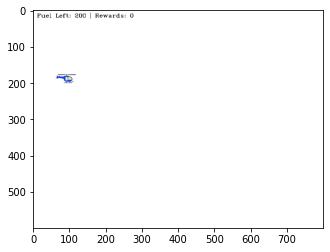

In [7]:
env = ChopperScape()
obs = env.reset()
plt.imshow(obs)

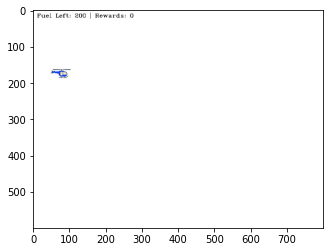

In [8]:
env = ChopperScape()
obs = env.reset()
screen = env.render(mode = "rgb_array")
plt.imshow(screen)

In [9]:
from IPython import display

env = ChopperScape()
obs = env.reset()


while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    
    # Render the game
    env.render()
    
    if done == True:
        break

env.close()

### test sample

In [10]:
for episode in range(10): 
    obs = env.reset()
    for step in range(50):
        action = env.action_space.sample()  # or given a custom model, action = policy(observation)
        nobs, reward, done, info = env.step(action)


In [11]:
def pre_process(image_frame):
    
   
    I = image_frame[60:] # Crop
    
    #print("Croped Image size : ",I.shape)
    I = cv2.resize(I,(256,256))
    
    I = I[::2, ::2, 0]


    
    return I.astype(np.float32).reshape(128,128,1)

Action :  4
Reward :  1
is done :  False
info :  []
Image size :  (600, 800, 3)


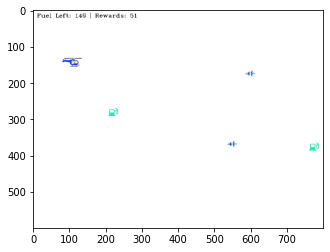

In [12]:
action = env.action_space.sample()
obs, reward, done, info = env.step(action)
print("Action : ",action)
print("Reward : ",reward)
print("is done : ",done)
print("info : ",info)
print("Image size : ",obs.shape)
plt.imshow(obs)

Pre process image :  (128, 128, 1)


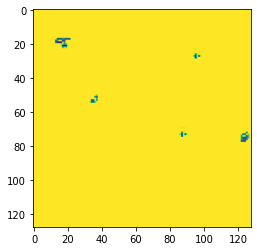

In [13]:
test_img = obs
pre_process_img = pre_process(test_img)
print("Pre process image : ",pre_process_img.shape)
plt.imshow(pre_process_img)

### Create model

In [14]:
IMG_SIZE = 128
n_actions = 5
MAX_ITERS= 100
learning_rate=1e-3

In [15]:
import tensorflow as tf

In [16]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape = (IMG_SIZE,IMG_SIZE,1)),
    tf.keras.layers.Conv2D(16,kernel_size=(7,7),strides = 4,activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(16,kernel_size=(7,7),strides = 4,activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(32,kernel_size=(5,5),strides = 2,activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(32,kernel_size=(3,3),strides = 2,activation = 'relu', padding = 'same'),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),strides = 2,activation = 'relu', padding = 'same'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 512, activation = tf.nn.relu),
    tf.keras.layers.Dense(units= 256, activation = tf.nn.relu),
    tf.keras.layers.Dense(units= 128, activation = tf.nn.relu),
    tf.keras.layers.Dense(units= n_actions,activation=None)
        
    ])
    
    return model

In [37]:
model = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        800       
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 16)          12560     
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 32)          12832     
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 32)          9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 1, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 512)              

###  RL logics

In [38]:
def normalize(x):
    x = x - np.mean(x)
    x =  x / np.std(x)
    
    return x.astype(np.float32) 

In [117]:
def isNan(val):
     return val != val

In [39]:
def discount_rewards(rewards, gamma = 0.99):
    discounted_rewards = np.zeros_like(rewards)
    
    R =  0 
    for t in reversed(range (0,len(rewards))):
        
        if rewards[t] != 0 :
            R = 0
        R = R * gamma + rewards[t]
        
        
        discounted_rewards[t] = R
        
    return normalize(discounted_rewards)


In [40]:
class Memory:
    def __init__(self):
        self.clear()
        
    
    def clear(self):
        self.observations = []
        self.actions = []
        self.rewards = []
        
    def add_to_memory(self,new_observation,new_action,new_reward):
        self.observations.append(new_observation)
        
        self.actions.append(new_action)
        
        self.rewards.append(new_reward)

In [129]:
def choose_action(model,observation):
    
    observation = np.expand_dims(observation,axis = 0)
    
    logits = model.predict(observation)
    
    prob_weights = tf.nn.softmax(logits).numpy()
    
    isContainNan =  [ isNan(x) for x in prob_weights.flatten()]
    
    if True in   isContainNan:
        return np.random.choice(n_actions,size = 1)[0]
    
    action = np.random.choice(n_actions,size = 1, p = prob_weights.flatten())[0]
    
    return action

In [130]:
### Loss function ###
def compute_loss(logits,actions,rewards):
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = actions)

    loss = tf.reduce_mean(neg_logprob * rewards)

    return loss


#### logging

In [131]:
import IPython
import time
from IPython import display as ipythondisplay

In [132]:
class LossHistory:
    def __init__(self, smoothing_factor=0.0):
        self.alpha = smoothing_factor
        self.loss = []
    def append(self, value):
        self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
    def get(self):
        return self.loss

In [133]:
class PeriodicPlotter:
    def __init__(self, sec, xlabel='', ylabel='', scale=None):

        self.xlabel = xlabel
        self.ylabel = ylabel
        self.sec = sec
        self.scale = scale

        self.tic = time.time()

    def plot(self, data):
        if time.time() - self.tic > self.sec:
            plt.cla()

            if self.scale is None:
                plt.plot(data)
            elif self.scale == 'semilogx':
                plt.semilogx(data)
            elif self.scale == 'semilogy':
                plt.semilogy(data)
            elif self.scale == 'loglog':
                plt.loglog(data)
            else:
                raise ValueError("unrecognized parameter scale {}".format(self.scale))

            plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
 
            self.tic = time.time()

In [134]:
# plotting
smoothed_reward = LossHistory(smoothing_factor=0.9)
plotter = PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')
memory = Memory()

In [135]:
### Training step (forward and backpropagation) ###
def train_step(model,optimizer,observations,actions,discounted_rewards):
    with tf.GradientTape() as tape:
        logits = model(observations)
        
        loss = compute_loss(logits,actions,discounted_rewards)
        
    grads = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))

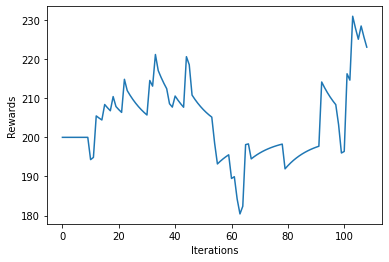

In [ ]:
for i_episode in range(MAX_ITERS):
    plotter.plot(smoothed_reward.get())
    
    # Restart the environment
    observation = env.reset()
    previous_frame = pre_process(observation)
    
    while True :
        current_frame =  pre_process(observation)
        
        obs_change = current_frame - previous_frame
        
        action = choose_action(model,obs_change)
        env.render()
        next_observation, reward, done, info = env.step(action)
        
        memory.add_to_memory(obs_change,action,reward)
        
        if done :
            
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)
            
            train_step(model,
                      optimizer,
                      observations = np.stack(memory.observations,0),
                      actions = np.array(memory.actions),
                      discounted_rewards = discount_rewards(memory.rewards))
            memory.clear()
            break
        
        observation = next_observation
        previous_frame = current_frame

In [137]:
 np.random.choice(n_actions,size = 1)

array([4])